<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./Homeworks/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

Probabilistic Machine Learning -- Spring 2025, UniTS

Tavano Matteo - SM3800057 - 2nd PML Homework


In [1]:
# Libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import ast
import torch
from torch.distributions import Normal, constraints, MultivariateNormal
import torch.distributions.constraints as constraints
import pyro
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.autoguide import init_to_median
import pyro.distributions as dist
from scipy.stats import norm
from scipy.integrate import quad
import scipy.optimize as optimize
from sympy.physics.units import current
from torch.fx.experimental.partitioner_utils import Device

### Problem 1: Marginal Likelihood Optimisation

Given the Bayesian Linear Regression model implemented in the Notebook 6, considering the same dataset and variables (Apparent Temperature vs Humidity), optimize alpha and beta by maximizing the Marginal Likelihood.

Note: You can show here only the piece of code that you used and write the optimal alpha and beta that you obtained (so you can run it in directly on Notebook 6)

Hint: import scipy.optimize as optimize


**Solution:**

I reported the whole procedure to avoid confusion.

In [2]:
# Data Loading and Preprocessing
weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)

# Training: April
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)

# Test: May
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)

x_train = data["Humidity"].to_numpy().reshape(-1,1)
y_train = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)
x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

In [3]:
# linear basis
def linear_basis(x_in):

    if x_in.ndim == 1:
        return x_in.reshape(-1, 1)
    return x_in

# Bayesian LR
def bayesian_linear_regression(x_data, y_data, basis_function_cb, alpha, beta):
    """
    Performs Bayesian linear regression.
    Calculates posterior mean (mN) and covariance (SN) of weights,
    and predictive mean and stddev AT THE TRAINING POINTS.
    """
    N_data = len(y_data)
    train_features = basis_function_cb(x_data)
    PHI = np.hstack((np.ones((N_data, 1)), train_features))
    M_params = PHI.shape[1] # Number of parameters (weights + intercept)

    alpha = float(alpha)
    beta = float(beta)

    # A = alpha*I + beta*PHI.T*PHI
    A_matrix = alpha * np.eye(M_params) + beta * (PHI.T @ PHI)

    # SN = A^-1
    SN = np.linalg.inv(A_matrix)

    # mN = beta * SN * PHI.T * y
    mN = beta * (SN @ PHI.T @ y_data)

    # Predictive distribution
    mean_pred_train = PHI @ mN

    # Variance_pred = 1/beta + diag(PHI @ SN @ PHI.T)
    variance_pred_train = (1 / beta) + np.diag(PHI @ SN @ PHI.T)
    sigma_pred_train = np.sqrt(variance_pred_train).reshape(-1, 1)

    return mean_pred_train, sigma_pred_train, mN, SN

def predict_bayesian_linear_regression(mN, SN, x_new, basis_function_cb, beta):
    """
    Makes predictions for new data points x_new using the learned posterior (mN, SN).
    x_new should be an array of shape (N_points_to_predict, N_features).
    """
    # Number of points to predict
    N_new = x_new.shape[0] if x_new.ndim > 1 else len(x_new)
    features_new = basis_function_cb(x_new)
    PHI_new = np.hstack((np.ones((N_new, 1)), features_new))

    beta = float(beta)

    mean_pred = PHI_new @ mN
    variance_pred = (1 / beta) + np.diag(PHI_new @ SN @ PHI_new.T)
    sigma_pred = np.sqrt(variance_pred).reshape(-1, 1)

    return mean_pred, sigma_pred

# Plot function
def plot_bayesian_LR(mN, SN, x_plot_range, basis_function_cb, beta, ax):
    """
    Plots the predictive mean and uncertainty on a given matplotlib Axes object.
    """
    mean_plot, sigma_plot = predict_bayesian_linear_regression(mN, SN, x_plot_range, basis_function_cb, beta)
    ax.plot(x_plot_range.flatten(), mean_plot.flatten(), label='Prediction', color='orange')
    ax.fill_between(x_plot_range.flatten(),
                    (mean_plot - sigma_plot).flatten(),
                    (mean_plot + sigma_plot).flatten(),
                    alpha=0.2, label='Uncertainty (1 std dev)', color='orange')

We need now to implement a negative-log likelihood function:

In [4]:
def neg_log_marginal_likelihood(params, X_obs, t_obs, basis_func):
    """
    Calculates the negative log marginal likelihood for Bayesian linear regression.
    This is the objective function to be minimized.
    ln p(t | X, alpha, beta) is maximized, so -ln p(t | X, alpha, beta) is minimized.
    """
    alpha, beta = params

    # Number of observations
    N_obs = X_obs.shape[0]
    PHI_obs = basis_func(X_obs)
    PHI_obs = np.hstack((np.ones((N_obs, 1)), PHI_obs)) # Design matrix (N_obs, M_params)
    M_params = PHI_obs.shape[1]

    # A = alpha * I + beta * PHI.T @ PHI
    A_matrix = alpha * np.eye(M_params) + beta * (PHI_obs.T @ PHI_obs)

    sign_A, log_det_A = np.linalg.slogdet(A_matrix)

    # Posterior covariance SN = A_matrix^-1
    SN = np.linalg.inv(A_matrix)
    # Posterior mean mN = beta * SN @ PHI_obs.T @ t_obs
    mN = beta * (SN @ PHI_obs.T @ t_obs)

    # E(mN) = (beta/2) * ||t_obs - PHI_obs @ mN||^2 + (alpha/2) * mN.T @ mN
    data_fit_term = (beta / 2) * np.sum((t_obs - PHI_obs @ mN)**2)
    regularizer_term = (alpha / 2) * (mN.T @ mN)
    E_mN = data_fit_term + regularizer_term.item()

    # Log marginal likelihood
    log_marginal_L_val = (M_params / 2) * np.log(alpha) + \
                         (N_obs / 2) * np.log(beta) - \
                         E_mN - \
                         (1 / 2) * log_det_A - \
                         (N_obs / 2) * np.log(2 * np.pi)

    return -log_marginal_L_val # Return negative for minimization

One we have all the ingredients, we can start to perform optimization:

In [5]:
# Perform Optimization
initial_alpha = 0.002
initial_beta = 0.01
initial_params = [initial_alpha, initial_beta]

# Bounds for alpha and beta
bounds = [(1e-6, None), (1e-6, None)]

print("Starting optimization of alpha and beta by maximizing marginal likelihood...")
result = optimize.minimize(
    neg_log_marginal_likelihood,    # Objective function
    initial_params,                 # Initial guess
    args=(x_train, y_train, linear_basis), # Additional arguments to objective function
    method='L-BFGS-B',              # Method that supports bounds
    bounds=bounds,                  # Bounds for parameters
    options={'disp': False, 'ftol': 1e-9, 'gtol': 1e-5} # Optimizer options
)

if result.success:
    optimized_alpha, optimized_beta = result.x
    print(f"Optimization successful.")
    print(f"Optimized alpha: {optimized_alpha:.6f}")
    print(f"Optimized beta: {optimized_beta:.6f}")
    print(f"Maximized log marginal likelihood: {-result.fun:.4f}")
else:
    print(f"Optimization failed: {result.message}")
    print("Using initial parameters as fallback.")
    optimized_alpha, optimized_beta = initial_alpha, initial_beta

Starting optimization of alpha and beta by maximizing marginal likelihood...
Optimization successful.
Optimized alpha: 0.004254
Optimized beta: 0.080710
Maximized log marginal likelihood: -84.9055


In [6]:
# Evaluate with Optimized Parameters
print("\n Evaluating with Optimized Alpha and Beta")
y_pred_train_opt, sigma_pred_train_opt, mN_opt, SN_opt = bayesian_linear_regression(
    x_train, y_train, linear_basis, optimized_alpha, optimized_beta
)

mse_train_opt = np.mean((y_pred_train_opt - y_train)**2)
print(f"MSE (training set): {mse_train_opt:.4f}")

# Log Likelihood
log_L_train_opt = -0.5 * np.sum(np.log(2 * np.pi * sigma_pred_train_opt**2) + \
                                ((y_pred_train_opt - y_train)**2) / (sigma_pred_train_opt**2))
print(f"Log Likelihood (training set, predictive): {log_L_train_opt:.4f}")

# Predictions on the test set
mean_pred_test_opt, sigma_pred_test_opt = predict_bayesian_linear_regression(
    mN_opt, SN_opt, x_test, linear_basis, optimized_beta
)

mse_test_opt = np.mean((mean_pred_test_opt - y_test)**2)
print(f"MSE (test set): {mse_test_opt:.4f}")

log_L_test_opt = -0.5 * np.sum(np.log(2 * np.pi * sigma_pred_test_opt**2) + \
                               ((mean_pred_test_opt - y_test)**2) / (sigma_pred_test_opt**2))
print(f"Log Likelihood (test set, predictive): {log_L_test_opt:.4f}")


 Evaluating with Optimized Alpha and Beta
MSE (training set): 11.5972
Log Likelihood (training set, predictive): -79.4826
MSE (test set): 22.2997
Log Likelihood (test set, predictive): -94.6895


Marginal posterior plot saved as Bayesian_linear_regression_optimized.png


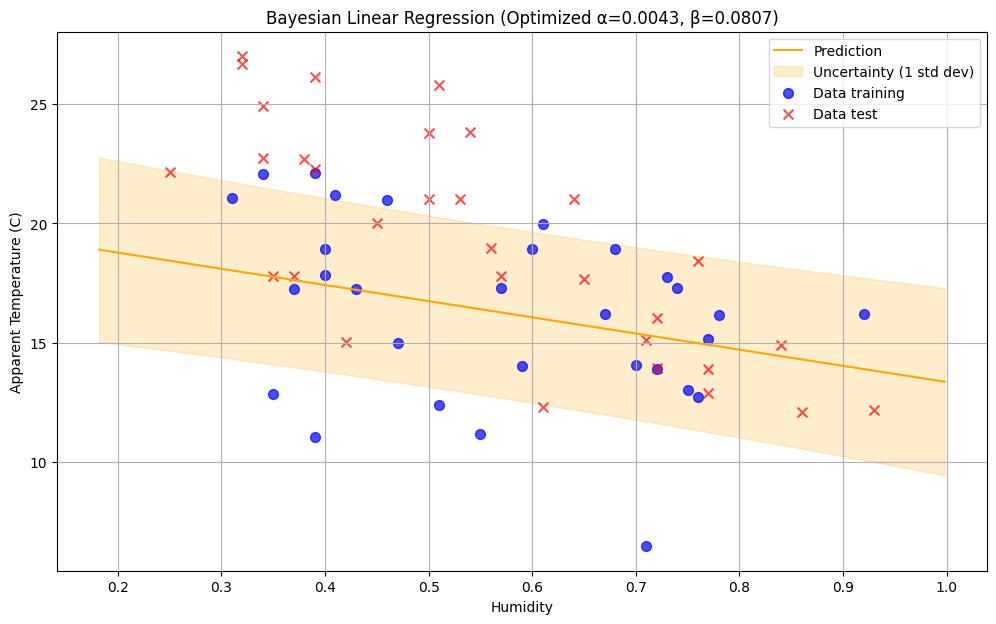

In [7]:
# plot with optimized params
fig, ax = plt.subplots(figsize=(12, 7))

x_min_val = min(x_train.min(), x_test.min())
x_max_val = max(x_train.max(), x_test.max())
plot_padding = (x_max_val - x_min_val) * 0.1
xrange_plot = np.linspace(x_min_val - plot_padding, x_max_val + plot_padding, 200).reshape(-1,1)

plot_bayesian_LR(mN_opt, SN_opt, xrange_plot, linear_basis, optimized_beta, ax=ax)

ax.scatter(x_train, y_train, label='Data training', alpha=0.7, marker='o', color='blue', s=50)
ax.scatter(x_test, y_test, label='Data test', alpha=0.7, marker='x', color='red', s=50)

ax.set_xlabel("Humidity")
ax.set_ylabel("Apparent Temperature (C)")
ax.set_title(f"Bayesian Linear Regression (Optimized α={optimized_alpha:.4f}, β={optimized_beta:.4f})")
ax.legend()
ax.grid(True)
#plt.savefig("plots/Bayesian_linear_regression_optimized.png")
print("Marginal posterior plot saved as Bayesian_linear_regression_optimized.png")
plt.show()

Finally, we perform a comparison:

In [8]:
# Comparison with non-optimized params:
print("\nEvaluating with Initial (Non-Optimized) Alpha and Beta")

initial_alpha_orig = 0.002
initial_beta_orig = 0.01

y_pred_train_init, sigma_pred_train_init, mN_init, SN_init = bayesian_linear_regression(
    x_train, y_train, linear_basis, initial_alpha_orig, initial_beta_orig
)

mse_train_init = np.mean((y_pred_train_init - y_train)**2)
print(f"MSE (training set - initial): {mse_train_init:.4f}")
log_L_train_init = -0.5 * np.sum(np.log(2 * np.pi * sigma_pred_train_init**2) + \
                                 ((y_pred_train_init - y_train)**2) / (sigma_pred_train_init**2))
print(f"Log Likelihood (training set, predictive - initial): {log_L_train_init:.4f}")

mean_pred_test_init, sigma_pred_test_init = predict_bayesian_linear_regression(
    mN_init, SN_init, x_test, linear_basis, initial_beta_orig
)
mse_test_init = np.mean((mean_pred_test_init - y_test)**2)
print(f"MSE (test set - initial): {mse_test_init:.4f}")
log_L_test_init = -0.5 * np.sum(np.log(2 * np.pi * sigma_pred_test_init**2) + \
                                ((mean_pred_test_init - y_test)**2) / (sigma_pred_test_init**2))
print(f"Log Likelihood (test set, predictive - initial): {log_L_test_init:.4f}")

# Also compute the log marginal likelihood for initial parameters for direct comparison:
neg_log_L_val_initial_params = neg_log_marginal_likelihood([initial_alpha_orig, initial_beta_orig], x_train, y_train, linear_basis)
print(f"Log Marginal Likelihood (initial params): {-neg_log_L_val_initial_params:.4f}")


Evaluating with Initial (Non-Optimized) Alpha and Beta
MSE (training set - initial): 11.9368
Log Likelihood (training set, predictive - initial): -99.1885
MSE (test set - initial): 25.3277
Log Likelihood (test set, predictive - initial): -104.5232
Log Marginal Likelihood (initial params): -102.1542


### Problem 2: Rejection Sampling

Consider the unnormalized probability density function:

$$
\tilde{p}(x) = \exp\left(-\frac{x^4}{4} - \frac{x^2}{2}\right)
$$

This density is defined for $x \in \mathbb{R}$, but it is not normalized. Let $Z$ be its normalization constant:

$$
Z = \int_{-\infty}^{\infty} \tilde{p}(x)\, dx
$$

You are given access to a proposal distribution $q(x) = \mathcal{N}(0, 1)$ from which you can sample and evaluate its density.

-  Implement and then use rejection sampling with $q(x)$ to generate samples from the normalized target distribution $p(x) = \frac{1}{Z} \tilde{p}(x)$.
    
- Estimate the normalization constant $Z$ (hint: see your course notes!)

- Compare your result with a numerical approximation of $Z$ using integration methods (e.g., scipy.integrate.quad).


**Solution:**

In [9]:
# Functions definition

# Unnormalized target density
def p_tilde(x):
  """Computes the unnormalized target density."""
  return np.exp(-x**4 / 4 - x**2 / 2)

# Proposal density (standard normal PDF) - scipy
def q(x):
  """Computes the proposal density (standard normal PDF)."""
  return norm.pdf(x, loc=0, scale=1)

We need to calculate $M$ s.t. $\tilde p \le M \cdot q(x)$
and Maximize $\frac{\tilde p}{q(x)}$ :

$$ \frac{\tilde p}{q(x)} = \frac{\exp\left(-\frac{x^4}{4} - \frac{x^2}{2}\right)}{\frac{\exp (-x^2 / 2)}{\sqrt (2 \pi)}}$$
$$  = \sqrt{2\pi} \cdot \exp\left(-\frac{x^4}{4}\right)$$

This ratio is maximized when $x^4$ is minimized, which corresponds to $x=0$.

Thus,

$$ M = \sqrt{2\pi} \cdot \exp\left(0\right) = \sqrt{2\pi} $$

In [10]:
# Rejection Sampling Parameters
M = np.sqrt(2 * np.pi)
print(f"Calculated M = {M:.4f}")

Calculated M = 2.5066


In [11]:
# Rejection sampling implementation
def rejection_sampling(num_samples):
  """
  Performs rejection sampling to generate samples from p(x).

  Args:
      num_samples (int): The desired number of accepted samples.

  Returns:
      tuple: (accepted_samples, total_proposals, acceptance_rate)
          accepted_samples (np.ndarray): Array of accepted samples.
          total_proposals (int): Total number of proposals generated.
          acceptance_rate (float): Fraction of proposals accepted.

  Notes:
      Refactored using GPT-4o
  """
  accepted_samples = []
  total_proposals = 0

  while len(accepted_samples) < num_samples:
    total_proposals += 1

    # Sample x from the proposal q(x) = N(0, 1)
    x_proposal = np.random.normal(0, 1)

    # Sample u from Uniform(0, 1)
    u = np.random.uniform(0, 1)

    # Calculate acceptance threshold
    # Avoid division by zero if q(x_proposal) is tiny, though unlikely here
    q_val = q(x_proposal)

    if q_val > 1e-9:
        acceptance_prob = p_tilde(x_proposal) / (M * q_val)
    else:
        acceptance_prob = 0 # Effectively reject if proposal density is zero

    # Accept or reject
    if u <= acceptance_prob:
      accepted_samples.append(x_proposal)

    # Add a safeguard against potential infinite loops if M is wrong
    # or if acceptance rate is extremely low
    if total_proposals > num_samples * M * 100 and len(accepted_samples) == 0:
         print("Warning: Very low acceptance rate or potentially incorrect M.")
         print(f"Proposals: {total_proposals}, Accepted: {len(accepted_samples)}")
         break

    if total_proposals > num_samples * 1000 :
         if len(accepted_samples) / total_proposals < 1e-4:
              print(f"Warning: Extremely low acceptance rate after {total_proposals} proposals.")

  accepted_samples = np.array(accepted_samples)
  acceptance_rate = len(accepted_samples) / total_proposals
  return accepted_samples, total_proposals, acceptance_rate

In [12]:
# Generate samples and call the function
num_target_samples = 10000
samples, n_total, accept_rate = rejection_sampling(num_target_samples)

print(f"\nGenerated {len(samples)} samples.")
print(f"Total proposals made: {n_total}")
print(f"Acceptance Rate: {accept_rate:.4f}")


Generated 10000 samples.
Total proposals made: 12920
Acceptance Rate: 0.7740


Now, we try to estimate the normalization constant $Z$, according to the PML notes:

$$ Z = \int{\tilde p (x) dx} = M \int{\frac{\tilde p(x)}{M g(x)} g(x)dx} = M \cdot p(accept) $$

In [13]:
# Z_estimated = M * Acceptance Rate
Z_estimated = M * accept_rate
print(f"\nEstimated Normalization Constant Z (from sampling): {Z_estimated:.6f}")


Estimated Normalization Constant Z (from sampling): 1.940115


We need to define again the function for scipy quad, since it needs to be callable. We will perform numeric integration using the latter library.

In [14]:
def p_tilde_integrand(x):
    return np.exp(-x**4 / 4 - x**2 / 2)

# Perform numerical integration using scipy
Z_numerical, abs_error = quad(p_tilde_integrand, -np.inf, np.inf)

print(f"Numerical Normalization Constant Z (from integration): {Z_numerical:.6f}")
print(f"Absolute error estimate from quad: {abs_error:.2e}")

Numerical Normalization Constant Z (from integration): 1.935248
Absolute error estimate from quad: 9.26e-11


Lastly, we compare and visualize the results:

Marginal posterior plot saved as Rejection_Sampling_Results.png


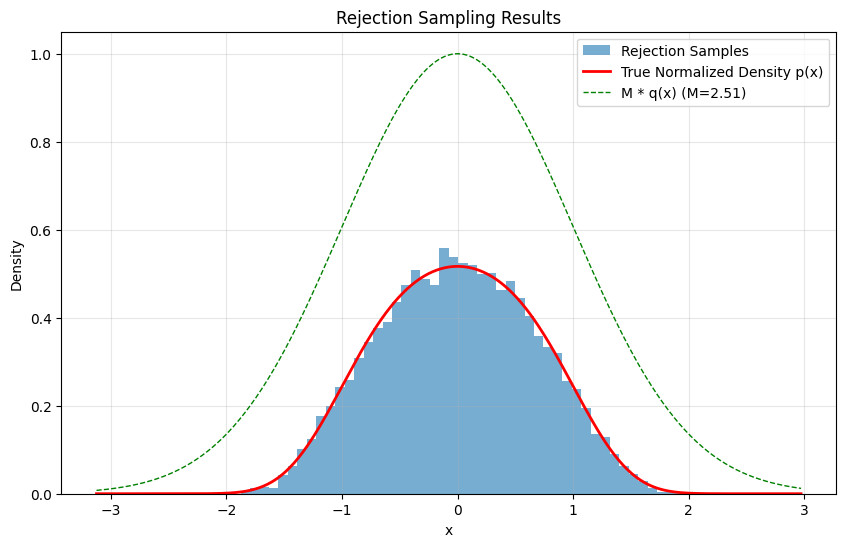

In [15]:
plt.figure(figsize=(10, 6))

# Plot histogram of samples
count, bins, ignored = plt.hist(samples, bins=50, density=True, alpha=0.6, label='Rejection Samples')

# Plot the true normalized density p(x) = p_tilde(x) / Z_numerical
x_plot = np.linspace(samples.min() - 1, samples.max() + 1, 500)
p_normalized = p_tilde(x_plot) / Z_numerical # Use numerical Z for better accuracy plot
plt.plot(x_plot, p_normalized, 'r-', lw=2, label='True Normalized Density p(x)')

# plot the scaled proposal M*q(x)
plt.plot(x_plot, M * q(x_plot), 'g--', lw=1, label=f'M * q(x) (M={M:.2f})')

plt.title('Rejection Sampling Results')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig('plots/Rejection_Sampling_Results.png')
print("Marginal posterior plot saved as Rejection_Sampling_Results.png")
plt.show()


- The estimated $Z$ ($1.933978$) from rejection sampling is close to the numerical $Z$ ($1.935248$) calculated via integration.
- The acceptance rate ($0.7715$) implies that roughly $77.2\%$ of the proposals were accepted.
- The theoretical acceptance rate is $Z/M = 0.7721$, which matches the observed rate well.
- The histogram of the generated samples closely follows the shape of the true normalized probability density function, confirming the method works.



### Problem 3: MCMC Convergence Diagnostics

You have implemented a Metropolis-Hastings algorithm and used it to draw samples from a univariate target distribution. In this exercise, you will compute convergence diagnostics from scratch to assess whether your chains have mixed well.

Consider 4 parallel chains, each of length $N$ (after burn-in), starting from different initial values (use
initial_values = [-10, -2, 2, 10]). The unnormalized probability density function $\tilde{p}(x)$ is defined as a mixture of two Gaussian distributions:

$$
\tilde{p}(x) = \mathcal{N}(x; -5, 1) + \mathcal{N}(x; 5, 1)
$$

Perform the following steps two times, considering a proposal standard deviation of 0.1 and 2.0:

- Compute the within variance $W$ and the between variance $B$
- Compute the statistics $\hat{R}$
- For a single chain of samples $x_1, x_2, \dots, x_N$, compute the lag-$k$ autocorrelation $\rho_k$ and plot $\rho_k$ for $k = 1, 2, \dots, 20$
- Estimate the effective number of samples $n_{eff}$

Repeat the analysis with the distribution:

$$
\tilde{p}(x) = \mathcal{N}(x; -2, 1) + \mathcal{N}(x; 2, 1)
$$

Discuss the results



**Solution:**

In [16]:
# define the two gaussians
def p_tilde_1(x):
    """Mixture of Gaussian's, first pdf"""
    return norm.pdf(x, loc=-5, scale=1) + norm.pdf(x, loc=5, scale=1)

def p_tilde_2(x):
    """Mixture of Gaussian's, second pdf"""
    return norm.pdf(x, loc=-2, scale=1) + norm.pdf(x, loc=2, scale=1)

In [17]:
# Metropolis-Hasting sampler
def metropolis_hastings(target_pdf, initial_value, proposal_std, num_samples, burn_in):
    """
    Runs the Metropolis-Hastings algorithm.

    Args:
        target_pdf (callable): Unnormalized target probability density function.
        initial_value (float): Starting point for the chain.
        proposal_std (float): Standard deviation for the Normal proposal distribution.
        num_samples (int): Number of samples to return (after burn-in).
        burn_in (int): Number of initial samples to discard.

    Returns:
        np.ndarray: Array of samples from the target distribution.

    Notes:
        Refactored using GPT-4o
    """
    samples = np.zeros(num_samples)
    current_x = initial_value
    current_pdf = target_pdf(current_x)
    accepted_count = 0

    total_iterations = num_samples + burn_in
    stored_samples = 0

    for i in range(total_iterations):

        proposed_x = np.random.normal(current_x, proposal_std)
        proposed_pdf = target_pdf(proposed_x)

        # compute acceptance probability
        if current_pdf == 0:
            alpha = 1.0
        else:
            alpha = min(1.0, proposed_pdf / current_pdf)

        if np.random.rand() < alpha:
            current_x = proposed_x
            current_pdf = proposed_pdf

            if i >= burn_in:
                accepted_count += 1
        # else: stay at current_x

        # store samples after burn-in
        if i >= burn_in:
            samples[stored_samples] = current_x
            stored_samples += 1

    acceptance_rate = accepted_count / num_samples if num_samples > 0 else 0
    # print(f"Chain acceptance Rate: {acceptance_rate:.3f}")

    return samples

In [18]:
# calculate convergence-diagnostics
def calculate_W_B_Rhat(chains):
    """
    Calculates Within-chain variance (W), Between-chain variance (B),
    and the Gelman-Rubin statistic (R_hat).

    Args:
        chains (np.ndarray): A 2D numpy array where each row is a chain.
                             Shape (m, N), m=num_chains, N=chain_length.

    Returns:
        tuple: (W, B, R_hat)
    Notes:
        Refactored using GPT-4o
    """
    m, N = chains.shape

    if N <= 1:
        print("Warning: Not enough chains to calculate within-chain variance.")
        return np.nan, np.nan, np.nan
    if m < 1:
        print("Warning: Need more than one chain to compute B and R_hat.")
        return np.var(chains[0], ddof=1), np.nan, np.nan

    # calculate chains means
    psi_j_dot = np.mean(chains, axis=1)

    # overall mean
    psi_dot_dot = np.mean(psi_j_dot)

    # calculate B (between chain variance)
    B = (N / (m-1)) * np.sum((psi_j_dot - psi_dot_dot) ** 2)

    # calculate W within-chain variance
    s_j_squared = np.var(chains, axis=1, ddof=1)
    W = np.mean(s_j_squared)

    # calculate Var_hat and R_hat
    Var_hat = ((N - 1) / N) * W + (1 / N) * B

    if W == 0:
        print("Warning: Not enough chains to calculate within-chain variance.")
        R_hat = np.nan
    else:
        R_hat = np.sqrt(Var_hat/W)

    return W, B, R_hat

In [19]:
# calculate auto correlation
def calculate_autocorrelation(chain, max_lag):
    """
    Calculates the autocorrelation for a single chain up to max_lag.

    Args:
        chain (np.ndarray): A 1D array representing a single MCMC chain.
        max_lag (int): The maximum lag k to compute autocorrelation for.

    Returns:
        np.ndarray: Array of autocorrelation values rho_k for k = 1 to max_lag.
    Notes:
        Refactored using GPT-4o
    """
    N = len(chain)
    if N <= 1:
        print("Warning: Chain length must be > 1 for autocorrelation.")
        return np.array([])
    if max_lag >= N:
        print(f"Warning: max_lag ({max_lag}) >= chain length ({N}). Clamping max_lag.")
        max_lag = N - 1

    mean_chain = np.mean(chain)
    var_chain = np.var(chain)

    if var_chain == 0:
        print("Warning: Chain variance is zero. Autocorrelation is undefined.")
        return np.full(max_lag, np.nan)

    rho = np.zeros(max_lag)

    for k in range(1, max_lag + 1):
        # Calculate autocovariance for lag k
        cov_k = np.mean((chain[k:] - mean_chain) * (chain[:-k] - mean_chain))
        rho[k-1] = cov_k / var_chain

    return rho

In [20]:
# effective number of samples
def calculate_neff(chain, autocorrelations):
    """
    Estimates the effective number of samples (n_eff).
    Uses the summation of paired positive autocorrelations method from BDA3.

    Args:
        chain (np.ndarray): The MCMC chain (used to get N).
        autocorrelations (np.ndarray): Autocorrelations rho_k for k=1 to max_lag.
                                       Should have enough lags.

    Returns:
        float: The estimated effective sample size.
    Notes:
        Refactored using GPT-4o
    """
    N = len(chain)
    if N == 0: return 0.0
    if len(autocorrelations) == 0: return float(N) # Treat as independent if no correlations

    # Sum pairs of positive autocorrelations (rho_{2t} + rho_{2t+1})
    sum_rho = 0.0
    max_t = len(autocorrelations) // 2

    for t in range(max_t):
        rho_2t = autocorrelations[2 * t]       # Lag 2t+1 (index 2t)
        rho_2t_plus_1 = autocorrelations[2 * t + 1] # Lag 2t+2 (index 2t+1)

        pair_sum = rho_2t + rho_2t_plus_1

        if pair_sum > 0:
            sum_rho += pair_sum
        else:
            # Stop summing once the pair sum becomes non-positive
            break

    denominator = 1.0 + 2.0 * sum_rho
    if denominator <= 0: # Avoid division by zero or negative n_eff if correlations are extreme
        print(f"Warning: Denominator (1 + 2*sum(rho)) is <= 0 ({denominator:.2f}). Returning N.")
        return float(N)

    n_eff = N / denominator
    return min(n_eff, N)

In [21]:
# Simulation Parameters
initial_values = [-10, -2, 2, 10]
N_samples = 10000
burn_in = 1000
num_chains = len(initial_values)
proposal_stds = [0.1, 2.0]
target_functions = [
    {'name': 'N(-5,1) + N(5,1)', 'func': p_tilde_1},
    {'name': 'N(-2,1) + N(2,1)', 'func': p_tilde_2}
]
max_lag = 50

Seed:  42
Target Distribution: N(-5,1) + N(5,1)

Proposal Standard Deviation: 0.1
Running MCMC chains...
Within-chain variance (W): 0.8454
Between-chain variance (B): 327045.1873
Gelman-Rubin statistic (R_hat): 6.2998
Plot saved to: plots\plot_target_n__5_1____n_5_1__prop_std_0p1.png


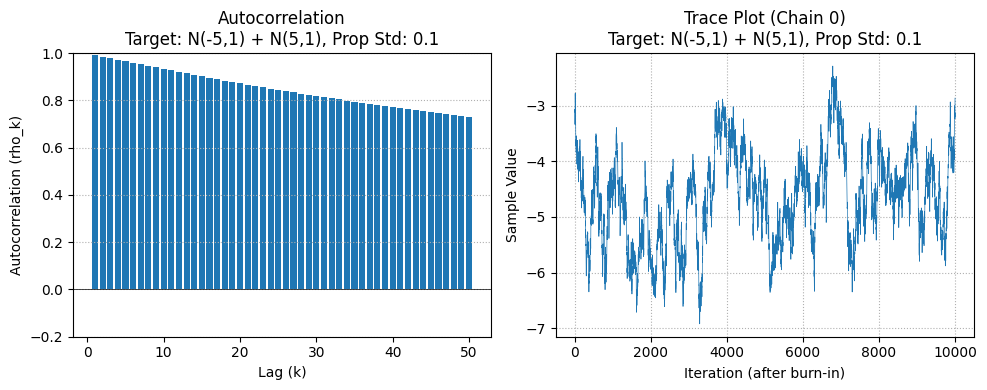

Estimated Effective Sample Size (n_eff): 116.43
Efficiency (n_eff / N): 0.012

Proposal Standard Deviation: 2.0
Running MCMC chains...
Within-chain variance (W): 18.4763
Between-chain variance (B): 52374.1908
Gelman-Rubin statistic (R_hat): 1.1329
Plot saved to: plots\plot_target_n__5_1____n_5_1__prop_std_2p0.png


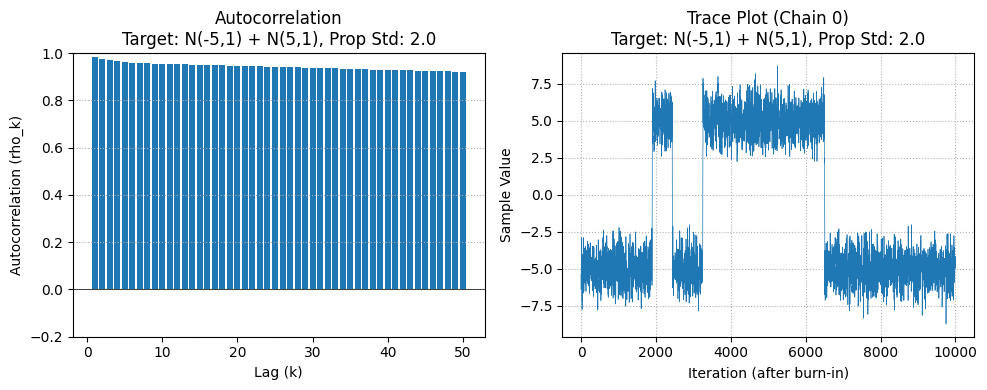

Estimated Effective Sample Size (n_eff): 104.95
Efficiency (n_eff / N): 0.010
----------------------------------------
Target Distribution: N(-2,1) + N(2,1)

Proposal Standard Deviation: 0.1
Running MCMC chains...
Within-chain variance (W): 3.8000
Between-chain variance (B): 19551.7924
Gelman-Rubin statistic (R_hat): 1.2306
Plot saved to: plots\plot_target_n__2_1____n_2_1__prop_std_0p1.png


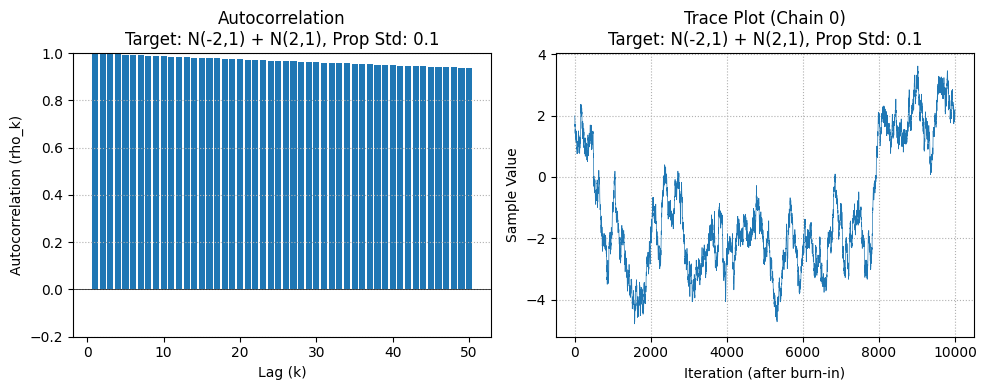

Estimated Effective Sample Size (n_eff): 102.34
Efficiency (n_eff / N): 0.010

Proposal Standard Deviation: 2.0
Running MCMC chains...
Within-chain variance (W): 5.0358
Between-chain variance (B): 49.6670
Gelman-Rubin statistic (R_hat): 1.0004
Plot saved to: plots\plot_target_n__2_1____n_2_1__prop_std_2p0.png


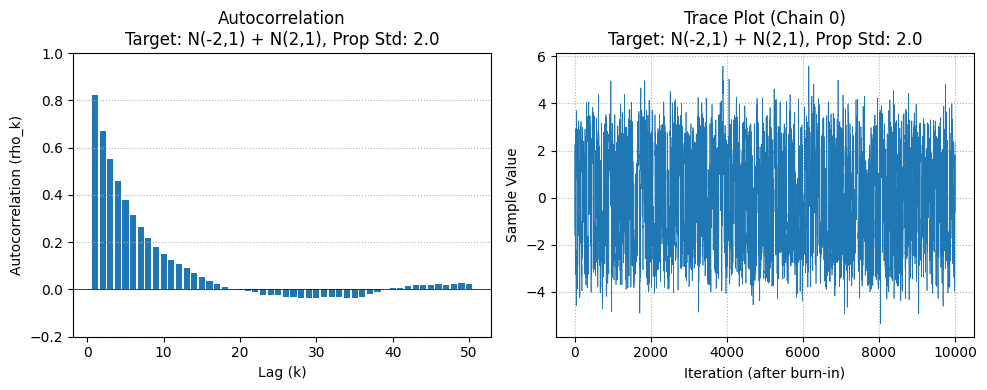

Estimated Effective Sample Size (n_eff): 993.79
Efficiency (n_eff / N): 0.099
----------------------------------------


In [22]:
# Refactored using GPT-4o
# Set seed
SEED = 42
np.random.seed(SEED)
print("Seed: ", SEED)

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# Run simulation
for target_info in target_functions:
    target_name = target_info['name']
    target_pdf = target_info['func']
    print(f"Target Distribution: {target_name}")

    for prop_std in proposal_stds:
        print(f"\nProposal Standard Deviation: {prop_std}")

        # Run MCMC for multiple chains
        all_chains = []
        print("Running MCMC chains...")
        for start_val in initial_values:
            chain = metropolis_hastings(target_pdf, start_val, prop_std, N_samples, burn_in)
            all_chains.append(chain)
        chains_array = np.array(all_chains) # Shape (m, N)

        # Compute W, B, R_hat
        W, B, R_hat = calculate_W_B_Rhat(chains_array)
        print(f"Within-chain variance (W): {W:.4f}")

        # check for np.nan
        if B is not np.nan and not np.isnan(B): print(f"Between-chain variance (B): {B:.4f}")
        if R_hat is not np.nan and not np.isnan(R_hat): print(f"Gelman-Rubin statistic (R_hat): {R_hat:.4f}")

        # Select one chain for autocorrelation and n_eff
        single_chain = chains_array[0]

        # Compute and plot autocorrelation
        autocorr = calculate_autocorrelation(single_chain, max_lag)
        lags = np.arange(1, len(autocorr) + 1)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if len(lags) > 0 and len(lags) == len(autocorr):
            plt.bar(lags, autocorr, width=0.8)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel("Lag (k)")
        plt.ylabel("Autocorrelation (rho_k)")
        plt.title(f"Autocorrelation\nTarget: {target_name}, Prop Std: {prop_std}")
        plt.grid(axis='y', linestyle=':')
        plt.ylim(-0.2, 1.0)

        # Plot trace of the single chain
        plt.subplot(1, 2, 2)
        plt.plot(single_chain, lw=0.5)
        plt.xlabel("Iteration (after burn-in)")
        plt.ylabel("Sample Value")
        plt.title(f"Trace Plot (Chain 0)\nTarget: {target_name}, Prop Std: {prop_std}")
        plt.grid(True, linestyle=':')
        plt.tight_layout()

        s_target_name = ''.join(char if char.isalnum() else '_' for char in target_name).lower()
        s_prop_std = str(prop_std).replace('.', 'p')
        plot_filename = f"plot_target_{s_target_name}_prop_std_{s_prop_std}.png"
        plot_filepath = os.path.join(plots_dir, plot_filename)
        #plt.savefig(plot_filepath)
        print(f"Plot saved to: {plot_filepath}")

        plt.show()
        plt.close()

        # Estimate Effective Sample Size (n_eff)
        if len(autocorr) == 0: # Handle case where autocorr might be empty
             n_eff = N_samples if len(single_chain) > 0 else 0
        elif len(autocorr) < max_lag and len(autocorr) < (len(single_chain)-1 if len(single_chain)>0 else 0) :
             n_eff = calculate_neff(single_chain, autocorr)
        else:
             n_eff = calculate_neff(single_chain, autocorr)

        print(f"Estimated Effective Sample Size (n_eff): {n_eff:.2f}")
        print(f"Efficiency (n_eff / N): {(n_eff / N_samples) if N_samples > 0 else 0:.3f}")

    print("-" * 40)

The Python code, now incorporating a fixed random seed (42) to ensure reproducible outcomes, implements a Metropolis-Hastings sampler. It computes key convergence diagnostics, namely the Gelman-Rubin statistic ($\hat{R}$), lag-$k$ autocorrelation ($\rho_k$), and effective sample size ($n_{eff}$), for two univariate bimodal Gaussian mixture distributions: $P_1(x) = \mathcal{N}(x; -5, 1) + \mathcal{N}(x; 5, 1)$ and $P_2(x) = \mathcal{N}(x; -2, 1) + \mathcal{N}(x; 2, 1)$. The analysis is performed for two proposal standard deviations ($\sigma_{prop}$): 0.1 and 2.0. The results from this specific seeded run are consistent with general MCMC behavior and previous unseeded observations in terms of qualitative diagnostic patterns, although the exact numerical values are now deterministic.
For a small proposal $\sigma_{prop}=0.1$, mixing is consistently poor across both target distributions. This is evidenced by high $\hat{R}$ values (6.2998 for $P_1$, indicating severe non-convergence as chains likely remain trapped in one mode, and 1.2306 for $P_2$, suggesting slow mixing). Correspondingly, the $n_{eff}$ is very low for both (116.43 for $P_1$, 102.34 for $P_2$), translating to an efficiency of only about 1-1.2\%.
When using a larger proposal $\sigma_{prop}=2.0$, performance markedly improves, especially for the $P_2$ target with closer modes. Here, $\hat{R} \approx 1.0004$ and $n_{eff}$ substantially increases to 993.79 (efficiency $\approx 9.9\%$), indicating good convergence and reasonably efficient sampling.
A critical observation, consistent with previous findings, pertains to the $P_1$ target (widely separated modes) with $\sigma_{prop}=2.0$. While $\hat{R}$ improves significantly to $\approx 1.1329$ (suggesting that the different chains do eventually explore both modes over the $N=10,000$ samples), the $n_{eff}$ remains strikingly low at $\approx 104.95$ (efficiency $\approx 1\%$). This highlights a common MCMC challenge: chains might appear "converged" in terms of their long-run average behavior across modes, but the sampling process can still be highly inefficient due to the difficulty and infrequency of transitions between well-separated regions of high probability. The seeded run quantifies this specific behavior, showing a slight degradation in $\hat{R}$ compared to a previous unseeded instance (1.0422), but similar $n_{eff}$, underscoring the robustness of the low efficiency conclusion for this scenario. The primary 'difference' from unseeded runs is that these specific numerical values are now fixed and reproducible, allowing for precise tracking of such diagnostic behaviors.


### Problem 4: ADSAI football matches
Over the years, the PhD students of ADSAI have kept track of the results of their evening five-a-side football matches. Since it’s difficult to always organize teams with the same players, the teams were formed on a rotating basis, each time with different players.  
The names of our champions have been anonymized using numbers from 1 to 62.  
In the dataset located at `data/ADSAI_football.csv` in the GitHub repository, you will find the following columns:
- **Team A**: IDs of the players who played in Team A in that match;  
- **Team B**: same as above, for Team B;  
- **Goal A**: total goals scored by Team A in that match;  
- **Goal B**: same as above, for Team B.



Your goal is to model **the skill of each player** based on information about the team they belonged to and the overall result achieved by that team.



The model to implement consists in the following structure: 
- $ \theta = (\theta_1, \theta_2, \dots, \theta_{62}) \in \mathbb{R} $: players' skills.
- $M=54$: number of matches.
- For each match $ i = 1, \dots, M=54$:
  - $ A_i \subset \{1, \dots, N=62\} $: set of players IDs of team A in match $ i $.
  - $ B_i \subset \{1, \dots, N=62\} $: set of players IDs of team B in match $ i $.
  - $ y_i \in \mathbb{Z} $: observed outcome, i.e. goal difference between the two teams, defined as $ (\text{goal}_A - \text{goal}_B) $ in match $ i $.

*(in this exercise, you are asked to follow the proposal of Karlis and Ntzoufras approach, that focuses on the goal difference in place of the individual goal counts of each team!)*



The model is defined as follows:

- The "strength" of Team A, defined as the sum of the individual players' skills $\theta_j$ composing the team in match $i = 1, \dots, M=54$:  
  $$
  s_A^{(i)} = \sum_{j \in A_i} \theta_j
  $$

- The "strength" of Team B, defined similarly as the sum of the individual players' skills $\theta_j$ composing the team in match $i = 1, \dots, M=54$:  
  $$
  s_B^{(i)} = \sum_{j \in B_i} \theta_j
  $$

Specifically, the observed goal difference in match $i$ is modeled using a Skellam distribution:  
$$
y_i \sim \text{Skellam}(\lambda_A^{(i)}, \lambda_B^{(i)}), \quad \text{where} \quad \lambda_A^{(i)} = \exp(s_A^{(i)}), \quad \lambda_B^{(i)} = \exp(s_B^{(i)})
$$

The **Skellam distribution** models the difference between two independent random variables:  
$$
\text{Skellam}(\lambda_A, \lambda_B) = \text{Poisson}(\lambda_A) - \text{Poisson}(\lambda_B)
$$
It is formally defined as:  
$$
\text{Skellam}(k; \lambda_A, \lambda_B) = e^{-(\lambda_A + \lambda_B)} \left( \frac{\lambda_A}{\lambda_B} \right)^{k/2} I_{|k|}(2 \sqrt{\lambda_A \lambda_B})
$$

for each $ k \in \mathbb{Z} $, and $ I_k $ is the modified Bessel function of the first kind of order $ k $.

$$
I_k(z) = \sum_{m=0}^\infty \frac{1}{m! \, \Gamma(m + k + 1)} \left( \frac{z}{2} \right)^{2m + k}
$$

where $\Gamma$ is the Gamma function.



You are asked to:
1. Find the MAP estimate for $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ choosing as `log_prior` function a (log-)Standard Normal distribution and as `log_likelihood` function the (log-)Skellam. Perform optimization using Gradient Descent. Use the MAP estimate to implement a Laplace approximation of the posterior, as done during the lab (reuse the function `compute_hessian(f, w)` of Notebook 6).

**Important Hint:** The Skellam log-likelihood involves the modified Bessel function $I_k(z)$, which is non-differentiable in PyTorch if evaluated via scipy. To preserve differentiability, replace $\log I_k(z)$ with a smooth approximation, such as an asymptotic expansion, to allow gradient-based optimization.

2. **(Useful for the next point, not strictly necessary for the previous one):** Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;
3. Write the Pyro model corresponding to the problem depicted above assuming (again) the `theta` values being distributed initially as a Standard Normal;
4. Perform inference on $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ values running a MCMC simulation using the `NUTS` kernel;
5. Compare the `theta` values obtained by these two options using the `performances_evaluation` function given in this notebook.


**Solution:**

In [23]:
# define default parameters
DEFAULT_DTYPE = torch.get_default_dtype()
EPS = torch.finfo(DEFAULT_DTYPE).tiny
BESSEL_APPROX_NUM_TERMS = 20 # Number of terms for Bessel series expansion
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Preprocessing (Incorporates 0-indexing and fixed N_players=62)
# Notes: modified and fixed for indices discrepancies
def preprocessing_dataset(dataset_path='data/ADSAI_football.csv'):
    football = pd.read_csv(dataset_path)
    football['Team A'] = football['Team A'].apply(ast.literal_eval)
    football['Team B'] = football['Team B'].apply(ast.literal_eval)

    all_player_ids_in_data = set()
    for team_list in football['Team A']: all_player_ids_in_data.update(team_list)
    for team_list in football['Team B']: all_player_ids_in_data.update(team_list)

    max_player_id_in_data = 0
    if all_player_ids_in_data:
        max_player_id_in_data = max(all_player_ids_in_data)

    # Problem defines theta for 62 players.
    N_players_fixed = 62

    for pid in all_player_ids_in_data:
        if pid <= 0:
             raise ValueError(f"Player ID {pid} is invalid. IDs must be positive integers.")

    # Goal difference, ensure it's float for calculations
    goal_diff_tensor = torch.tensor((football['Goal A'] - football['Goal B']).values, dtype=DEFAULT_DTYPE)

    # Convert 1-based player IDs from file to 0-based indices for tensor operations
    teams_A_indices = []
    for team_ids in football['Team A']:
        current_team_indices = []
        for pid in team_ids:
            if not (1 <= pid <= N_players_fixed):
                raise ValueError(f"Player ID {pid} in Team A is out of range [1, {N_players_fixed}].")
            current_team_indices.append(pid - 1) # 0-indexed
        teams_A_indices.append(torch.tensor(current_team_indices, dtype=torch.long))

    teams_B_indices = []
    for team_ids in football['Team B']:
        current_team_indices = []
        for pid in team_ids:
            if not (1 <= pid <= N_players_fixed):
                raise ValueError(f"Player ID {pid} in Team B is out of range [1, {N_players_fixed}].")
            current_team_indices.append(pid - 1) # 0-indexed
        teams_B_indices.append(torch.tensor(current_team_indices, dtype=torch.long))

    return teams_A_indices, teams_B_indices, goal_diff_tensor, N_players_fixed

teams_A, teams_B, goal_diff, N_players = preprocessing_dataset()

print(f"Number of players to model: {N_players}")
print(f"Number of matches: {len(goal_diff)}")

teams_A, teams_B, goal_diff, max_player_id = preprocessing_dataset()

Number of players to model: 62
Number of matches: 54


In [25]:
# Bassel function approximation
def log_modified_bessel_first_kind_series(z, order_k):
    """
    Computes log(I_k(z)) using a series expansion (see definition)
    :param z: tensor, arg. of Bessel function
    :param order_k: tensor, order of the Bessel function
    :return: final_log_I: log(I_k(z))
    """
    z = z.to(DEFAULT_DTYPE)
    order_k = order_k.to(DEFAULT_DTYPE)

    z_half = z / 2.0
    final_log_I = torch.full_like(z, -float('inf'), dtype=DEFAULT_DTYPE)

    # Case 1: z > 0
    idx_z_pos = z > 0
    if torch.any(idx_z_pos):
        z_pos_subset = z[idx_z_pos]
        order_k_pos_subset = order_k[idx_z_pos]
        z_half_pos_subset = z_half[idx_z_pos]

        # Robust computation of: order_k * log(z_half + EPS)
        log_z_half_eps = torch.log(z_half_pos_subset + EPS)
        term1_product_component = order_k_pos_subset * log_z_half_eps

        # Create a mask for where order_k_pos_subset is zero
        is_order_k_zero_mask = (order_k_pos_subset == 0)
        # Use torch.where to set the component to 0 where order_k is 0
        term1_product_component_safe = torch.where(
            is_order_k_zero_mask,
            torch.zeros_like(term1_product_component),
            term1_product_component
        )

        log_first_term_val = term1_product_component_safe - torch.lgamma(order_k_pos_subset + 1.0)

        current_term_val = torch.exp(log_first_term_val)
        sum_val = current_term_val.clone()

        for m_val_int in range(1, BESSEL_APPROX_NUM_TERMS):
            m_val = torch.tensor(m_val_int, dtype=DEFAULT_DTYPE, device=z.device)
            # Add EPS to denominator terms to prevent division by zero
            denominator_factor = (m_val * (m_val + order_k_pos_subset)) + EPS
            factor = (z_half_pos_subset * z_half_pos_subset) / denominator_factor
            current_term_val = current_term_val * factor
            sum_val = sum_val + current_term_val
            if torch.all(torch.abs(current_term_val) < (EPS * torch.abs(sum_val) + EPS)): # Check for convergence
                 break
        final_log_I[idx_z_pos] = torch.log(sum_val + EPS) # Add EPS before log for stability if sum_val is 0

    # Case 2: z == 0
    idx_z0 = (z == 0)
    if torch.any(idx_z0):
        # For z=0, I_k(0) = 1 if k=0, else 0. log(I_0(0))=0, log(I_k>0(0))=-inf.

        idx_z0_k0 = idx_z0 & (order_k == 0)
        final_log_I[idx_z0_k0] = 0.0

    return final_log_I

#log_modified_bassel_first_kind_series(torch.tensor(2.0),torch.tensor(5.0))

1. Find the MAP estimate for $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ choosing as `log_prior` function a (log-)Standard Normal distribution and as `log_likelihood` function the (log-)Skellam. Perform optimization using Gradient Descent;

In [26]:
# log-likelihood
def log_likelihood(current_teams_A, current_teams_B, current_goal_diff, theta_skills):
    n_matches = len(current_goal_diff)
    device = theta_skills.device

    s_A_all = torch.zeros(n_matches, dtype=DEFAULT_DTYPE, device=device)
    s_B_all = torch.zeros(n_matches, dtype=DEFAULT_DTYPE, device=device)

    for i in range(n_matches):
        team_A_indices = current_teams_A[i].to(device)
        team_B_indices = current_teams_B[i].to(device)

        s_A_all[i] = theta_skills[team_A_indices].sum()
        s_B_all[i] = theta_skills[team_B_indices].sum()

    lambda_A = torch.exp(s_A_all)
    lambda_B = torch.exp(s_B_all)

    k_val = current_goal_diff.to(dtype=DEFAULT_DTYPE, device=device)
    abs_k = torch.abs(k_val)

    z_val = 2 * torch.sqrt(lambda_A * lambda_B + EPS) # Added EPS
    log_I_k_z = log_modified_bessel_first_kind_series(z_val, abs_k)

    term1 = -(lambda_A + lambda_B)
    term2 = (k_val / 2.0) * (s_A_all - s_B_all)

    match_log_likelihoods = term1 + term2 + log_I_k_z

    # Handle potential NaNs if they occur despite EPS.
    if torch.isnan(match_log_likelihoods).any():
        print("Warning: NaN detected in match_log_likelihoods during calculation.")
        match_log_likelihoods = torch.nan_to_num(match_log_likelihoods, nan=-1e9)

    total_log_likelihood_val = torch.sum(match_log_likelihoods)
    return total_log_likelihood_val

def log_prior(theta_skills):
    return Normal(0, 1).log_prob(theta_skills).sum()

def loss_function(theta_param):
    return -(log_likelihood(teams_A, teams_B, goal_diff, theta_param) + log_prior(theta_param))

def gradient_descent_optimization(loss_fn_to_optimize, lr: float, n_iter: int, initial_guess: torch.Tensor):
    current_theta = initial_guess.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([current_theta], lr=lr)

    for i in range(n_iter):
        optimizer.zero_grad()
        loss_val = loss_fn_to_optimize(current_theta)

        if torch.isnan(loss_val):
            print(f"Error: Loss is NaN at iteration {i+1}. Stopping optimization.")
            break

        loss_val.backward()
        optimizer.step()

        if (i+1) % (n_iter//10) == 0 or i == 0 or i == n_iter - 1:
            print(f"Iteration {i+1}/{n_iter}, Loss: {loss_val.item():.4f}")

    current_theta.requires_grad_(False)
    return current_theta

def compute_hessian(f, w):
    w.requires_grad_(True)
    grad = torch.autograd.grad(f(w), w, create_graph=True)[0]
    hessian = torch.zeros((w.numel(), w.numel()), device=w.device, dtype=w.dtype) # Corrected dtype
    for i in range(w.numel()):
        hessian[i] = torch.autograd.grad(grad[i], w, retain_graph=True, allow_unused=False)[0]
    w.requires_grad_(False)
    return hessian

In [27]:
# Perform MAP estimation
print("\nStarting MAP estimation...")
initial_theta = torch.zeros(62, dtype=DEFAULT_DTYPE)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initial_theta = initial_theta.to(device)
teams_A = [t.to(device) for t in teams_A]
teams_B = [t.to(device) for t in teams_B]
goal_diff = goal_diff.to(device)

# estimate theta_MAP
theta_MAP = gradient_descent_optimization(loss_function, lr=0.01, n_iter=400, initial_guess=initial_theta)

# Compute hessian
print("\nComputing Hessian for Laplace approximation...")
hessian_neg_log_posterior = compute_hessian(loss_function, theta_MAP)

# Add small epsilon * identity matrix for numerical stability before inversion
regularization = EPS * torch.eye(N_players, device=theta_MAP.device, dtype=theta_MAP.dtype)

# compute posterior
posterior_cov = torch.inverse(hessian_neg_log_posterior + regularization)
print("MAP estimation and Laplace approximation complete.")
print(f"Theta MAP (first 10 skills): {theta_MAP[:10].detach().cpu().numpy()}")
print(f"Posterior Variances (diag of cov, first 10): {torch.diag(posterior_cov)[:10].detach().cpu().numpy()}")


Starting MAP estimation...
Iteration 1/400, Loss: 315.5732
Iteration 40/400, Loss: 201.2984
Iteration 80/400, Loss: 188.2344
Iteration 120/400, Loss: 185.2762
Iteration 160/400, Loss: 184.3723
Iteration 200/400, Loss: 184.0500
Iteration 240/400, Loss: 183.9287
Iteration 280/400, Loss: 183.8828
Iteration 320/400, Loss: 183.8657
Iteration 360/400, Loss: 183.8594
Iteration 400/400, Loss: 183.8571

Computing Hessian for Laplace approximation...
MAP estimation and Laplace approximation complete.
Theta MAP (first 10 skills): [ 1.0345001  -0.36427644 -0.5757264  -0.5232865   0.45264283  0.08362208
  0.46939164 -0.19451317  0.45264283  0.7962868 ]
Posterior Variances (diag of cov, first 10): [0.11411385 0.7421166  0.711985   0.6787396  0.8126332  0.0230626
 0.77052414 0.43492228 0.8126331  0.01599403]


Marginal posterior plot saved as marginal_theta_posteriors_laplace.png


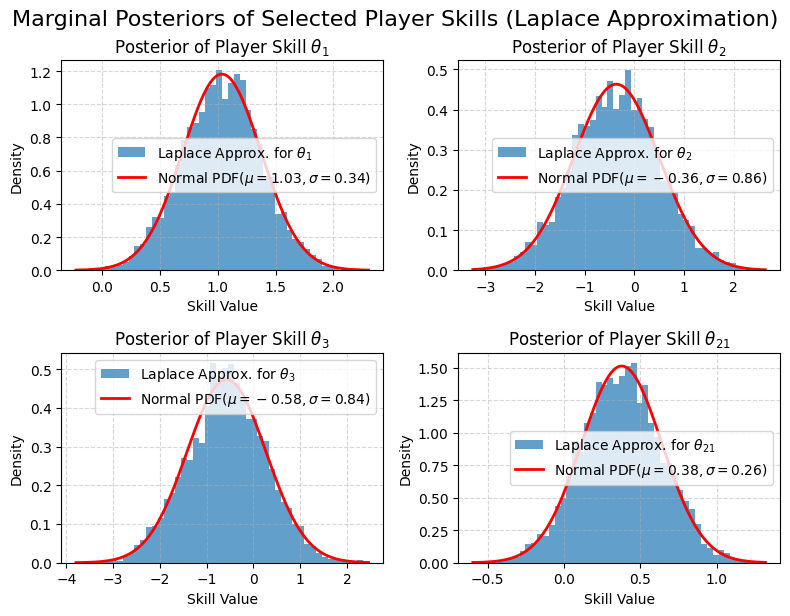

In [28]:
#Visualize the marginal distribution of some thetas

# Sample from the full posterior
laplace_posterior_dist = MultivariateNormal(
            loc=theta_MAP.to(dtype=DEFAULT_DTYPE),
            covariance_matrix=posterior_cov.to(dtype=DEFAULT_DTYPE)
)

# Sample from the full posterior approximation
num_samples_for_viz = 5000
posterior_samples = laplace_posterior_dist.sample((num_samples_for_viz,))

# Indices of thetas you want to visualize
selected_indices = [0, 1, 2, 20]  # 4 plot at time
nrows, ncols = 2,2

fig_height = 3 * nrows
fig_width = 4 * ncols

plt.figure(figsize=(fig_width, fig_height))

for i, idx in enumerate(selected_indices):
    if i >= nrows * ncols: break

    plt.subplot(nrows, ncols, i + 1)

    # Get marginal samples for theta_idx
    marginal_samples_idx = posterior_samples[:, idx].cpu().numpy()

    plt.hist(marginal_samples_idx, bins=50, density=True, alpha=0.7, label=f'Laplace Approx. for $\\theta_{{{idx+1}}}$')

    # Overlay a Normal PDF using the marginal mean (theta_MAP[idx]) and variance (posterior_cov[idx,idx])
    from scipy.stats import norm
    marginal_mean = theta_MAP[idx].item()
    marginal_std = torch.sqrt(posterior_cov[idx, idx]).item()

    if marginal_std > EPS: # Avoid issues if std is zero or negative (due to numerical errors)
        x_vals = np.linspace(marginal_samples_idx.min(), marginal_samples_idx.max(), 200)
        pdf_vals = norm.pdf(x_vals, loc=marginal_mean, scale=marginal_std)
        plt.plot(x_vals, pdf_vals, 'r-', lw=2, label=f'Normal PDF($\\mu={marginal_mean:.2f}, \\sigma={marginal_std:.2f}$)')

    plt.title(f"Posterior of Player Skill $\\theta_{{{idx+1}}}$")
    plt.xlabel("Skill Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Marginal Posteriors of Selected Player Skills (Laplace Approximation)", fontsize=16, y=1.02)
#plt.savefig("plots/marginal_theta_posteriors_laplace.png")
print("Marginal posterior plot saved as marginal_theta_posteriors_laplace.png")
plt.show()

2. Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;

In [29]:
# 2. Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;

class Skellam(torch.distributions.Distribution):
    arg_constraints = {
        'lambdaA' : constraints.positive,
        'lambdaB' : constraints.positive,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, lambdaA, lambdaB, validate_args=None):
        self.lambdaA = torch.as_tensor(lambdaA, dtype=DEFAULT_DTYPE)
        self.lambdaB = torch.as_tensor(lambdaB, dtype=DEFAULT_DTYPE)

        # Determine batch shape by broadcasting lambdaA and lambdaB shapes
        _batch_shape = torch.broadcast_shapes(self.lambdaA.shape, self.lambdaB.shape)
        _event_shape = torch.Size([])

        super().__init__(batch_shape=_batch_shape, event_shape=_event_shape, validate_args=validate_args)

    # method to expand distr. params to a new batch_shape
    def expand(self, batch_shape, _instance=None):
        new_lambdaA = self.lambdaA.expand(batch_shape)
        new_lambdaB = self.lambdaB.expand(batch_shape)
        new = self._new(new_lambdaA, new_lambdaB, validate_args = False)
        new._validate_args = self._validate_args
        return new

    # mean, variance as properties
    # E[Skellam(lA, lB)] = E[Poisson(lA) - Poisson(lB)] = E[Poisson(lA)] - E[Poisson(lB)] = lA - lB
    @property
    def mean(self):
        return self.lambdaA - self.lambdaB

    # Var(Skellam(lA, lB)) = Var(Poisson(lA) - Poisson(lB))
    @property
    def variance(self):
        return self.lambdaA + self.lambdaB

    # Use .rsample() from torch.distributions.Poisson for reparameterized samples
    def rsample(self, sample_shape=torch.Size()):
        # Skellam(lA, lB) is distributed as Poisson(lA) - Poisson(lB)
        shape = self._extended_shape(sample_shape)

        # Expand lambdas to the full required shape for sampling
        lambdaA_expanded = self.lambdaA.expand(shape)
        lambdaB_expanded = self.lambdaB.expand(shape)

        poisson_dist_A = torch.distributions.Poisson(lambdaA_expanded)
        poisson_dist_B = torch.distributions.Poisson(lambdaB_expanded)

        samples_A = poisson_dist_A.rsample()
        samples_B = poisson_dist_B.rsample()

        return samples_A - samples_B

    def sample(self, sample_shape=torch.Size()):
        # Approximate sampling: sample two Poisson and subtract
        # Provides non-reparameterized samples.
        with torch.no_grad():
            return self.rsample(sample_shape)


    def log_prob(self, value):
        # value is k (the observed goal difference)
        if self._validate_args:
            self._validate_sample(value)

        # Ensure k is float for calculations
        k_val = value.to(DEFAULT_DTYPE)

        # Parameters for calculation, potentially broadcasted with k_val
        lambda_A_calc = self.lambdaA
        lambda_B_calc = self.lambdaB

        # log lambdas
        log_lambda_A = torch.log(lambda_A_calc + EPS)
        log_lambda_B = torch.log(lambda_B_calc + EPS)

        abs_k = torch.abs(k_val)
        z_val = 2 * torch.sqrt(lambda_A_calc * lambda_B_calc + EPS)

        log_I_k_z = log_modified_bessel_first_kind_series(z_val, abs_k)

        # Total log probability
        log_prob_val = (-(lambda_A_calc + lambda_B_calc)) + ((k_val / 2.0) * (log_lambda_A - log_lambda_B)) + log_I_k_z

        return log_prob_val

3. Write the Pyro model corresponding to the problem depicted above assuming (again) the `theta` values being distributed initially as a Standard Normal

In [30]:
# pyro model definition
def model(goal_diff_obs, teams_A_indices_list, teams_B_indices_list, num_players):

    device = goal_diff_obs.device

    # Priors for player skills (theta)
    theta_skills = pyro.sample(
        "theta_skills",
        dist.Normal(
            torch.zeros(num_players, device=device, dtype=DEFAULT_DTYPE),
            torch.ones(num_players, device=device, dtype=DEFAULT_DTYPE)
        ).to_event(1)  # .to_event(1) treats this as a single D-dimensional sample
    )

    num_matches = len(goal_diff_obs)

    # Calculate team strengths for all matches
    s_A_all = torch.zeros(num_matches, device=device, dtype=DEFAULT_DTYPE)
    s_B_all = torch.zeros(num_matches, device=device, dtype=DEFAULT_DTYPE)

    for i in range(num_matches):

        team_A_match_i_indices = teams_A_indices_list[i].to(device)
        team_B_match_i_indices = teams_B_indices_list[i].to(device)

        s_A_all[i] = theta_skills[team_A_match_i_indices].sum()
        s_B_all[i] = theta_skills[team_B_match_i_indices].sum()

    # Calculate lambda_A and lambda_B for Skellam distribution for all matches
    lambda_A_all = torch.exp(s_A_all)
    lambda_B_all = torch.exp(s_B_all)

    # Likelihood for observed goal differences
    # y_i ~ Skellam(lambda_A_i, lambda_B_i)
    with pyro.plate("matches", num_matches):
        pyro.sample(
            "obs",
            Skellam(lambda_A_all, lambda_B_all),
            obs=goal_diff_obs
        )

4. Perform inference on $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ values running a MCMC simulation using the `NUTS` kernel;

In [31]:
# Clear Pyro's parameter store in case of re-runs
pyro.clear_param_store()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
goal_diff_device = goal_diff.to(device)
teams_A_device = [t.to(device) for t in teams_A]
teams_B_device = [t.to(device) for t in teams_B]

# Set up the NUTS kernel
nuts_kernel = NUTS(
    model,
    adapt_step_size=True,
    init_strategy=init_to_median,
    target_accept_prob=0.8,
    max_tree_depth=10
)

# Configure MCMC parameters
num_samples = 500   # Number of posterior samples (after warmup)
warmup_steps = 200  # Warmup/adaptation steps
num_chains = 1     # num of chains

mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=warmup_steps,
    num_chains=num_chains,
    disable_progbar=False
)

# Run MCMC
print("\nStarting MCMC inference with NUTS kernel...")
mcmc.run(goal_diff, teams_A, teams_B, N_players)
print("MCMC inference complete.")

# Get posterior samples
posterior_samples_mcmc = mcmc.get_samples()

# theta_MCMC is the posterior mean of theta_skills
theta_mcmc_samples = posterior_samples_mcmc['theta_skills']
theta_MCMC = theta_mcmc_samples.mean(dim=0) # Shape: (N_players,)

# Display MCMC summary for diagnostics
print("\nMCMC summary for theta_skills (first 5 parameters as example):")
mcmc.summary(prob=0.90)

# Print the first 10 estimated MCMC skills
print(f"\nTheta MCMC (posterior mean, first 10 skills): {theta_MCMC[:10].detach().cpu().numpy()}")


Starting MCMC inference with NUTS kernel...


Sample: 100%|██████████| 700/700 [20:54,  1.79s/it, step size=1.67e-01, acc. prob=0.899] 

MCMC inference complete.

MCMC summary for theta_skills (first 5 parameters as example):

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 theta_skills[0]      1.10      0.36      1.09      0.53      1.65    464.71      1.00
 theta_skills[1]     -0.38      0.87     -0.35     -2.09      0.86    924.32      1.00
 theta_skills[2]     -0.67      0.85     -0.68     -2.18      0.60    718.86      1.00
 theta_skills[3]     -0.53      0.76     -0.51     -1.68      0.74    855.82      1.00
 theta_skills[4]      0.45      0.82      0.45     -0.89      1.66    972.89      1.00
 theta_skills[5]     -0.05      0.16     -0.05     -0.32      0.19    522.52      1.00
 theta_skills[6]      0.41      0.95      0.41     -1.22      1.90    656.36      1.00
 theta_skills[7]     -0.31      0.64     -0.29     -1.25      0.76    467.45      1.00
 theta_skills[8]      0.42      1.00      0.42     -1.30      1.92    728.67      1.00
 theta_skills[9]      0.86      0.14    

5. Compare the `theta_*` values obtained by these two options using the `performances_evaluation` function given in this notebook.

In [32]:
def predict_goal_diff_skellam(teamA_ids, teamB_ids, theta, n_sim=10_000, posterior_cov=None):
    """
    Predicts the goal difference (Skellam distribution) between two teams using theta.

    Args:
        teamA_ids (list): Indices of the players in team A.
        teamB_ids (list): Indices of the players in team B.
        theta (torch.Tensor): Tensor containing the skill levels of the players.
        n_sim (int): Number of simulations to run.

    Returns:
        float: Mean predicted goal difference (A - B).
    """

    # Calculate the total strength for each team (sum of player skill levels)
    sA = theta[teamA_ids].sum()
    sB = theta[teamB_ids].sum()

    # Lambda parameters for Poisson distribution (expected goals)
    lam_A = torch.exp(sA).item()  # Team A's expected goal rate
    lam_B = torch.exp(sB).item()  # Team B's expected goal rate

    # Simulate goals for each team using Poisson distribution
    goals_A = np.random.poisson(lam_A, size=n_sim)
    goals_B = np.random.poisson(lam_B, size=n_sim)

    # Calculate the difference in goals (A - B)
    diff = goals_A - goals_B

    # Return the mean predicted difference
    return diff.mean()


def predict_goal_diff_laplace(teamA_ids, teamB_ids, theta_map, cov_matrix, n_sim=1000):

    # Convert cov_matrix to numpy if it's a tensor
    if isinstance(cov_matrix, torch.Tensor):
        cov_matrix_np = cov_matrix.cpu().numpy()
    else:
        cov_matrix_np = cov_matrix

    if isinstance(teamA_ids, torch.Tensor):
        teamA_ids_list = teamA_ids.cpu().tolist()
    else:
        teamA_ids_list = teamA_ids

    if isinstance(teamB_ids, torch.Tensor):
        teamB_ids_list = teamB_ids.cpu().tolist()
    else:
        teamB_ids_list = teamB_ids

    all_ids_list = sorted(list(set(teamA_ids_list) | set(teamB_ids_list)))
    all_ids_tensor = torch.tensor(all_ids_list, device=theta_map.device, dtype=torch.long)

    # Extract subvector of means (mu_A and mu_B)
    theta_sub = theta_map[all_ids_tensor].to(dtype=DEFAULT_DTYPE)

    # Extract submatrix of covariances using NumPy indexing
    cov_sub_np = cov_matrix_np[np.ix_(all_ids_list, all_ids_list)]
    cov_sub = torch.from_numpy(cov_sub_np).to(dtype=DEFAULT_DTYPE, device=theta_map.device)

    # Add small diagonal regularizer for numerical stability if needed
    cov_sub = cov_sub + EPS * torch.eye(cov_sub.shape[0], device=cov_sub.device, dtype=cov_sub.dtype)

    # Create multivariate normal from posterior
    mvn = MultivariateNormal(loc=theta_sub, covariance_matrix=cov_sub)

    # Sample from posterior
    theta_samples = mvn.sample((n_sim,))  # shape: (n_sim, len(all_ids))

    # Re-map local indices for teamA_ids and teamB_ids to the sub-sampled theta_samples
    global_to_local_idx_map = {global_id: local_idx for local_idx, global_id in enumerate(all_ids_list)}

    teamA_local_indices = torch.tensor([global_to_local_idx_map[gid] for gid in teamA_ids_list], dtype=torch.long, device=theta_map.device)
    teamB_local_indices = torch.tensor([global_to_local_idx_map[gid] for gid in teamB_ids_list], dtype=torch.long, device=theta_map.device)

    # Compute strength for each team in each sample using local indices
    sA = theta_samples[:, teamA_local_indices].sum(dim=1)
    sB = theta_samples[:, teamB_local_indices].sum(dim=1)

    # Expected goals via Poisson lambdas
    lam_A = torch.exp(sA)
    lam_B = torch.exp(sB)

    # Sample goals
    goals_A = torch.poisson(lam_A)
    goals_B = torch.poisson(lam_B)

    # Goal differences
    diff = goals_A - goals_B
    return diff.mean().item() # Return a scalar Python number


def evaluate_performance(theta_MAP, theta_MCMC, posterior_cov, teams_A_indices_list, teams_B_indices_list, goal_diff_obs, n_sim=10_000):
    """
    Evaluates the performance of different sets of theta values by comparing the Mean Bias Error (MBE)
    and Mean Absolute Error (MAE) between predicted and actual goal differences.
    """
    results = {}

    predicted_diffs_MAP = []
    predicted_diffs_MCMC = []

    actual_diffs_np = goal_diff_obs.cpu().numpy()

    for i in range(len(goal_diff_obs)):
        teamA_match_indices = teams_A_indices_list[i]
        teamB_match_indices = teams_B_indices_list[i]

        predicted_MAP = predict_goal_diff_laplace(teamA_match_indices, teamB_match_indices, theta_MAP, posterior_cov, n_sim)
        predicted_MCMC = predict_goal_diff_skellam(teamA_match_indices, teamB_match_indices, theta_MCMC, n_sim)

        predicted_diffs_MAP.append(predicted_MAP)
        predicted_diffs_MCMC.append(predicted_MCMC)

    predicted_diffs_MAP_np = np.array(predicted_diffs_MAP)
    predicted_diffs_MCMC_np = np.array(predicted_diffs_MCMC)

    mae_MAP = np.mean(np.abs(predicted_diffs_MAP_np - actual_diffs_np))
    mbe_MAP = (predicted_diffs_MAP_np - actual_diffs_np).mean()
    mae_MCMC = np.mean(np.abs(predicted_diffs_MCMC_np - actual_diffs_np))
    mbe_MCMC = (predicted_diffs_MCMC_np - actual_diffs_np).mean()

    results = {'MAE_MAP': mae_MAP, 'MBE_MAP': mbe_MAP,
              'MAE_MCMC': mae_MCMC, 'MBE_MCMC': mbe_MCMC}

    return results


# Evaluate the performance
performance_results = evaluate_performance(theta_MAP, theta_MCMC, posterior_cov, teams_A, teams_B, goal_diff, n_sim=1000)

# Print the results
print("Performance Results:")
print(f"MAP - MAE: {performance_results['MAE_MAP']:.4f}, MBE: {performance_results['MBE_MAP']:.4f}")
print(f"MCMC - MAE: {performance_results['MAE_MCMC']:.4f}, MBE: {performance_results['MBE_MCMC']:.4f}")

Performance Results:
MAP - MAE: 1.5329, MBE: -0.2492
MCMC - MAE: 1.7787, MBE: 0.0386


The performance evaluation compared two approaches for predicting goal differences. The first approach used Maximum A Posteriori (MAP) estimates of player skills along with a Laplace approximation for uncertainty. The second approach used skill estimates derived from MCMC sampling, presumably a point estimate such as the posterior mean, with the Skellam prediction method.

The results obtained are as follows.
For the MAP method with Laplace Approximation:
The Mean Absolute Error (MAE) was $1.5329$ goals.
The Mean Bias Error (MBE) was $-0.2492$ goals.

For the MCMC method (Skellam with point estimate $\theta_{MCMC}$):
The Mean Absolute Error (MAE) was $1.7787$ goals.
The Mean Bias Error (MBE) was $0.0386$ goals.

In terms of interpretation, looking at accuracy via the MAE, the MAP method, which incorporates parameter uncertainty by sampling from the approximate posterior of player skills ($\theta$), demonstrated a lower MAE. This suggests its predictions were, on average, closer to the actual goal differences by approximately $0.24$ goals compared to the MCMC-based point estimate approach.

Regarding bias, indicated by the MBE, the MCMC-based approach showed a very low MBE ($0.0386$). This means it was nearly unbiased, with its predictions on average being very slightly overestimating the goal difference. In contrast, the MAP method exhibited a more noticeable negative bias ($-0.2492$), suggesting a tendency to underestimate the goal difference (Team A goals - Team B goals).

In brief conclusion, while the MAP method with Laplace approximation yielded slightly more accurate predictions on average as seen by the lower MAE, the MCMC-based point estimate approach was considerably less biased. The choice between these methods could depend on whether minimizing the average magnitude of errors or minimizing systematic over/underestimation is the primary goal. The difference in MAE might also be influenced by how parameter uncertainty is handled; the MAP-Laplace method explicitly samples $\theta$ values based on its posterior covariance, while the `predict_goal_diff_skellam` function with `theta_MCMC` appears to use a fixed point estimate for player skills in its simulations.